In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *
from qiskit.quantum_info.analysis import average_data
from qiskit.quantum_info import state_fidelity
from sklearn.metrics import accuracy_score
import numpy as np

np.random.seed(0)

In [2]:
y = np.array(([1,0]))
y1 = np.array(([0,1]))
State_labels = [y,y1]

In [3]:
def circuit(params,X,y):
    
    n_qubits = len(params)
    layers = len(params[0][0])
    qc = QuantumCircuit(n_qubits)
    
    
    for i in range(len(params)):
        
        for id,j in enumerate(params[i]):
            qc.u3(X[0],X[1],0,i)
            
            qc.u3(j[0],j[1],j[2],i)
            if n_qubits > 1 and (id < layers-1):
                qc.cz(0,1)
                
    backend_sim = Aer.get_backend('statevector_simulator')

    job_sim = execute(qc, backend_sim)

    result_sim = job_sim.result()
    
    counts = result_sim.get_statevector(qc)
    if y == 0:
        
        vals = state_fidelity(counts,State_labels[0])
    else:
        vals = state_fidelity(counts,State_labels[1])
    #print(average_data(counts,vals))
    return vals

In [4]:
def cost(params,X,y):
    
    value = 0
    
    for i in range(len(X)):
        value = value + (1-circuit(params,X[i],y[i]))
    return value/len(X)
        

In [5]:
def gradient(params,x,y):
    
    g = np.zeros(params.shape)
    
    for qubit in range(len(params)):
        
        for layer in range(len(params[qubit])):
            
            for val in range(len(params[qubit][layer])):
                
        
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                F1 = cost(params,x,y)
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
                
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
    
                F2 = cost(params,x,y)
                
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                g[qubit][layer][val] = (F1-F2)/2
    return g
    
def optimize(params,X,y,lr): 
    g = gradient(params,X,y)
    
    new_weights = params - (lr*g)
    
    return new_weights

In [6]:
def _circle(samples):
    centers = np.array([[0, 0]])
    radii = np.array([np.sqrt(1.2/np.pi)])
    data=[]
    dim = 2
    labels=[]
    np.random.seed(1000)
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y = 0
        for c, r in zip(centers, radii):  
            if np.linalg.norm(x - c) < r:
                y = 1 

        data.append(x)
        labels.append(y)
            
    return np.array(data), np.array(labels)

(900, 2) (100, 2)


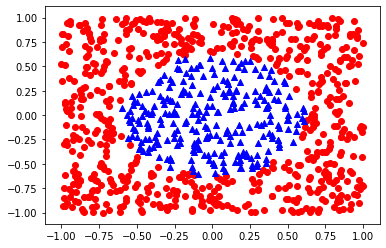

In [7]:
from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt
X,l = _circle(1000)
#X,l = make_moons(n_samples=900,random_state=0,noise=0.04)
x_train,x_test,y_train,y_test = train_test_split(X,l,test_size=0.1,random_state=0)
print(x_train.shape,x_test.shape)
scale = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scale.transform(x_train)
x_test = scale.transform(x_test)

plt.scatter(x_train[:,0][y_train==0], x_train[:,1][y_train==0], marker='o', color='red', label='train 0')
plt.scatter(x_train[:,0][y_train==1], x_train[:,1][y_train==1], marker='^', color='blue', label='train 1')

In [8]:
def predict(params,X):
    
    n_qubits = len(params)
    layers = len(params[0][0])
    qc = QuantumCircuit(n_qubits)
    
    
    for i in range(len(params)):
        
        for id,j in enumerate(params[i]):
            qc.u3(X[0],X[1],0,i)
            
            qc.u3(j[0],j[1],j[2],i)
            if n_qubits > 1 and (id < layers-1):
                qc.cz(0,1)
                
    backend_sim = Aer.get_backend('statevector_simulator')

    job_sim = execute(qc, backend_sim)

    result_sim = job_sim.result()
    
    counts = result_sim.get_statevector(qc)
    
        
    vals = state_fidelity(counts,State_labels[0])
    
    vals1 = state_fidelity(counts,State_labels[1])
    #print(average_data(counts,vals))
    if vals > vals1:
        return abs(1-vals)
    else:
        
        return vals1
    

In [19]:
from tqdm import tqdm
np.random.seed(5)
params = np.random.randn(1,5,3)
weights = params
score = -np.inf
lr = 0.2
test_loss = []
for i in range(500):
    
    index = np.random.randint(0,len(x_train),5)
    x_batch,y_batch = x_train[index],y_train[index]
    #if i+1 == 500 or i+1 == 800:
     #   lr = lr - 0.05
    weights = optimize(weights,x_batch,y_batch,lr=lr)
    
    res = [predict(weights,x) for x in x_test]
    test_loss.append(res)
    acc_test = accuracy_score(y_test,np.round(np.array(res)))
        
    if acc_test > score:
        score = acc_test
        var = weights
    print(
        "Epoch: {:2d} | testing accuracy: {:4f}".format(i+1,acc_test))

Epoch:  1 | testing accuracy: 0.450000
Epoch:  2 | testing accuracy: 0.480000
Epoch:  3 | testing accuracy: 0.490000
Epoch:  4 | testing accuracy: 0.500000
Epoch:  5 | testing accuracy: 0.490000
Epoch:  6 | testing accuracy: 0.490000
Epoch:  7 | testing accuracy: 0.500000
Epoch:  8 | testing accuracy: 0.520000
Epoch:  9 | testing accuracy: 0.520000
Epoch: 10 | testing accuracy: 0.520000
Epoch: 11 | testing accuracy: 0.530000
Epoch: 12 | testing accuracy: 0.540000
Epoch: 13 | testing accuracy: 0.540000
Epoch: 14 | testing accuracy: 0.550000
Epoch: 15 | testing accuracy: 0.560000
Epoch: 16 | testing accuracy: 0.550000
Epoch: 17 | testing accuracy: 0.580000
Epoch: 18 | testing accuracy: 0.580000
Epoch: 19 | testing accuracy: 0.580000
Epoch: 20 | testing accuracy: 0.590000
Epoch: 21 | testing accuracy: 0.630000
Epoch: 22 | testing accuracy: 0.640000
Epoch: 23 | testing accuracy: 0.630000
Epoch: 24 | testing accuracy: 0.640000
Epoch: 25 | testing accuracy: 0.640000
Epoch: 26 | testing accur

Epoch: 209 | testing accuracy: 0.930000
Epoch: 210 | testing accuracy: 0.910000
Epoch: 211 | testing accuracy: 0.920000
Epoch: 212 | testing accuracy: 0.920000
Epoch: 213 | testing accuracy: 0.920000
Epoch: 214 | testing accuracy: 0.910000
Epoch: 215 | testing accuracy: 0.910000
Epoch: 216 | testing accuracy: 0.920000
Epoch: 217 | testing accuracy: 0.910000
Epoch: 218 | testing accuracy: 0.910000
Epoch: 219 | testing accuracy: 0.910000
Epoch: 220 | testing accuracy: 0.910000
Epoch: 221 | testing accuracy: 0.920000
Epoch: 222 | testing accuracy: 0.910000
Epoch: 223 | testing accuracy: 0.910000
Epoch: 224 | testing accuracy: 0.910000
Epoch: 225 | testing accuracy: 0.920000
Epoch: 226 | testing accuracy: 0.900000
Epoch: 227 | testing accuracy: 0.900000
Epoch: 228 | testing accuracy: 0.920000
Epoch: 229 | testing accuracy: 0.910000
Epoch: 230 | testing accuracy: 0.910000
Epoch: 231 | testing accuracy: 0.910000
Epoch: 232 | testing accuracy: 0.910000
Epoch: 233 | testing accuracy: 0.910000


Epoch: 414 | testing accuracy: 0.910000
Epoch: 415 | testing accuracy: 0.900000
Epoch: 416 | testing accuracy: 0.910000
Epoch: 417 | testing accuracy: 0.900000
Epoch: 418 | testing accuracy: 0.910000
Epoch: 419 | testing accuracy: 0.900000
Epoch: 420 | testing accuracy: 0.900000
Epoch: 421 | testing accuracy: 0.920000
Epoch: 422 | testing accuracy: 0.880000
Epoch: 423 | testing accuracy: 0.880000
Epoch: 424 | testing accuracy: 0.890000
Epoch: 425 | testing accuracy: 0.890000
Epoch: 426 | testing accuracy: 0.890000
Epoch: 427 | testing accuracy: 0.880000
Epoch: 428 | testing accuracy: 0.890000
Epoch: 429 | testing accuracy: 0.880000
Epoch: 430 | testing accuracy: 0.890000
Epoch: 431 | testing accuracy: 0.890000
Epoch: 432 | testing accuracy: 0.890000
Epoch: 433 | testing accuracy: 0.880000
Epoch: 434 | testing accuracy: 0.900000
Epoch: 435 | testing accuracy: 0.890000
Epoch: 436 | testing accuracy: 0.890000
Epoch: 437 | testing accuracy: 0.900000
Epoch: 438 | testing accuracy: 0.910000


In [20]:
pred = []
z = []

for j in range(len(x_test)):
    pred.append(predict(var,x_test[j]))


In [21]:
print(accuracy_score(np.array(pred).round(),y_test))

from sklearn.metrics import confusion_matrix,classification_report

print(classification_report(np.array(pred).round(),y_test))


0.97
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        74
         1.0       0.90      1.00      0.95        26

    accuracy                           0.97       100
   macro avg       0.95      0.98      0.96       100
weighted avg       0.97      0.97      0.97       100



In [41]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 70), np.linspace(-1, 1, 70))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
X_grid = scale.transform(X_grid)
#X_grid = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_grid)
plt.figure()
cm = plt.cm.magma_r
predictions_grid = [predict(var, x) for x in X_grid]


<Figure size 432x288 with 0 Axes>

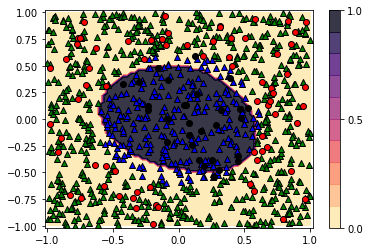

In [42]:
Z = np.reshape(predictions_grid, xx.shape).round()

cnt = plt.contourf(xx, yy, Z, levels=np.arange(0., 1.1, 0.1), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])
plt.scatter(x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], c='g', marker='^', edgecolors='k')
plt.scatter(x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], c='b', marker='^', edgecolors='k')
plt.scatter(x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], c='r', marker='o', edgecolors='k')
plt.scatter(x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], c='black', marker='o', edgecolors='k')

plt.ylim(-1.02, 1.02)
plt.xlim(-1.02, 1.02)
plt.show()

In [ ]:
params

In [ ]:
lr

In [ ]:
lr*0.5

In [33]:
(y_test==0).sum()

71